# DCGAN Ensemble Model 2 (seGANs) training

In this notebook we will continue training the second GAN ensembles following [Ensembles of Generative Adversarial Networks](https://arxiv.org/pdf/1612.00991.pdf) paper.

__Ensemble Model 2 (EM2): Self-ensemble of GANs (seGANs)__.

> (seGANs combines) models which are based on the same initialization of the parameters but only differ in the number of training iterations. This would have the advantage over eGANs that it is not necessary to train each GAN in the ensemble from scratch. As a consequence it is much faster to train seGANs than eGANs.

> We found that the results of GAN did not further improve after 30 epochs of training. We therefore use 30 epochs for all our trained models. For seGANs we randomly pick models between 30 and 40 epochs of training.

> We have run seGANs by combining more than two GANs, we have considered ensembles
of 2, 4, 6, and 8 GANs (see Table 2b). And then results are repeated 10 times. Results shown in
Fig 4(right) show that the average increase in k-nearest distance decreases, when increasing the
number of networks in the ensemble, but levels off from 4 to 8.


In short, we will:

* In trainig phase: after reaching a given epoch number, we will start to save snapshoots of the model at that point in time, and continue training until max number of epochs. They also mentioned that because the model didn't improve after epoch 30, they start picking model snapshoots randomly, from epoch 30 to 40. So in our case, as we saw while training DCGAN CM, after epoch 35 the quality of images didn't increase much, and also the generator loss varied the least, we will choose 8 models snapshoots between epoch 35 and 65. This number of 8 models is directly taken from seGANs tests done in the paper.

* In generation phase: we do the same as eGANs, we choose one of the models randomly each time we need to generate a sample image.

Lets import dependencies and define some basic helper functions. For this training we will use helpers in em2 folder.

In [1]:
import os
import time
import glob
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl
import numpy as np
from PIL import Image, ImageOps
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid

# EM2/seGANs helpers
from commons.utils import is_train_on_gpu, view_samples
from commons import data_helpers, gan_models
from em2 import train_helpers

In [2]:
dataset_path = 'data/alzheimers_mri_dataset/train'
models_folder = 'em2/models'
# using an odd batch size, if we use 64 the last batch will have only 1 img and will error out,
# instead if we use 63, the last batch will have 41 images which is ok
batch_size = 63
img_size = 128

demented_dataset, demented_train_loader = data_helpers.get_dataset_dataloader(batch_size, img_size, dataset_path)
print(f'dataset size: {len(demented_dataset)}')

dataset size: 2561


In [3]:
# clean models folder
!rm -rf em2/models
!mkdir -p em2/models

In [4]:
# Hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 200

# default hyperparams values according to DCGAN paper
# learning_rate = 0.0002
# beta1 = 0.5
# beta2 = 0.999
# but adding a small variation in learning rate,
#   changing it made the generator and discriminator losses stabilised a bit more quickly
learning_rate = 0.0001
beta1 = 0.5
beta2 = 0.999

n_epochs = 65
print_every = 100

In [5]:
# EM2 / seGANs hyperparam
# set number of models to train,
# and its epoch index randomly from which we want to save it
number_of_models_to_train = 8
index_models_to_save = np.random.randint(35, 66, number_of_models_to_train)
print('index_models_to_save:', index_models_to_save)

index_models_to_save: [65 43 46 39 62 49 39 52]


In [6]:
losses_list = []
start_time = time.time()

print(f' >>> training models started')
# create discriminator and generator instances
D, G = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), learning_rate, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), learning_rate, [beta1, beta2])

losses = train_helpers.train(
    demented_train_loader, D, G, d_optimizer, g_optimizer, z_size, n_epochs=n_epochs, print_every=print_every,
    index_models_to_save=index_models_to_save,
    models_folder=models_folder
)
print(f' >>> training models finished')

elapsed_time = time.time() - start_time
elapsed_time_hrs = elapsed_time / 60
print(' *** seGANs models trained successfully %ssec %smin' % (elapsed_time, elapsed_time_hrs))

 >>> training models started
 >>> training started
Epoch [    1/   65] | d_loss: 2.4372 | g_loss: 12.2136
Epoch [    2/   65] | d_loss: 2.1168 | g_loss: 64.8366
Epoch [    3/   65] | d_loss: 0.3061 | g_loss: 6.7057
Epoch [    4/   65] | d_loss: 4.1426 | g_loss: 27.2418
Epoch [    5/   65] | d_loss: 0.0045 | g_loss: 10.1440
Epoch [    6/   65] | d_loss: 1.1102 | g_loss: 2.3156
Epoch [    7/   65] | d_loss: 0.7582 | g_loss: 17.0917
Epoch [    8/   65] | d_loss: 0.2030 | g_loss: 8.7078
Epoch [    9/   65] | d_loss: 0.0477 | g_loss: 17.1089
Epoch [   10/   65] | d_loss: 1.7250 | g_loss: 24.7351
Epoch [   11/   65] | d_loss: 0.2017 | g_loss: 10.7595
Epoch [   12/   65] | d_loss: 0.0712 | g_loss: 8.9523
Epoch [   13/   65] | d_loss: 1.6023 | g_loss: 15.3445
Epoch [   14/   65] | d_loss: 0.0233 | g_loss: 9.1245
Epoch [   15/   65] | d_loss: 0.3554 | g_loss: 6.5888
Epoch [   16/   65] | d_loss: 0.1912 | g_loss: 7.7789
Epoch [   17/   65] | d_loss: 2.3293 | g_loss: 4.4055
Epoch [   18/   65] | 

Things to notice:

* Two new values to train function are passed, `index_models_to_save` and `models_folder`. The first one is going to work as a conditional check if we need to save the state of the model at a certain epoch, and the second one is just the folder where we are going to save this state.

* Range of `(34, 65)` was set, as the target epochs, because we observed in past training of CM, that after epoch 35 the quality of images didn't increase much, and also the generator loss varied the least.

* In the past notebook, we saved 8 models from scratch, now we are saving 8 models in the same training process but in different epochs.

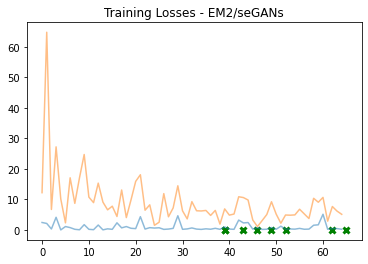

In [7]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
# show from which epochs models were saved
ax.scatter(index_models_to_save, np.zeros(number_of_models_to_train), marker='x', color='g', linewidths=3)
plt.title(f"Training Losses - EM2/seGANs")
plt.show()

After plotting losses and marking in which epoch models were saved, we can see those were chosen in the last epochs, between 35 and 65, just as we defined the setup. Also we can see that in the most cases the loss for each of these generators is low.

 *** instantiating model: em2/models/segan65
 *** instantiating model: em2/models/segan43
 *** instantiating model: em2/models/segan46
 *** instantiating model: em2/models/segan39
 *** instantiating model: em2/models/segan62
 *** instantiating model: em2/models/segan49
 *** instantiating model: em2/models/segan39
 *** instantiating model: em2/models/segan52


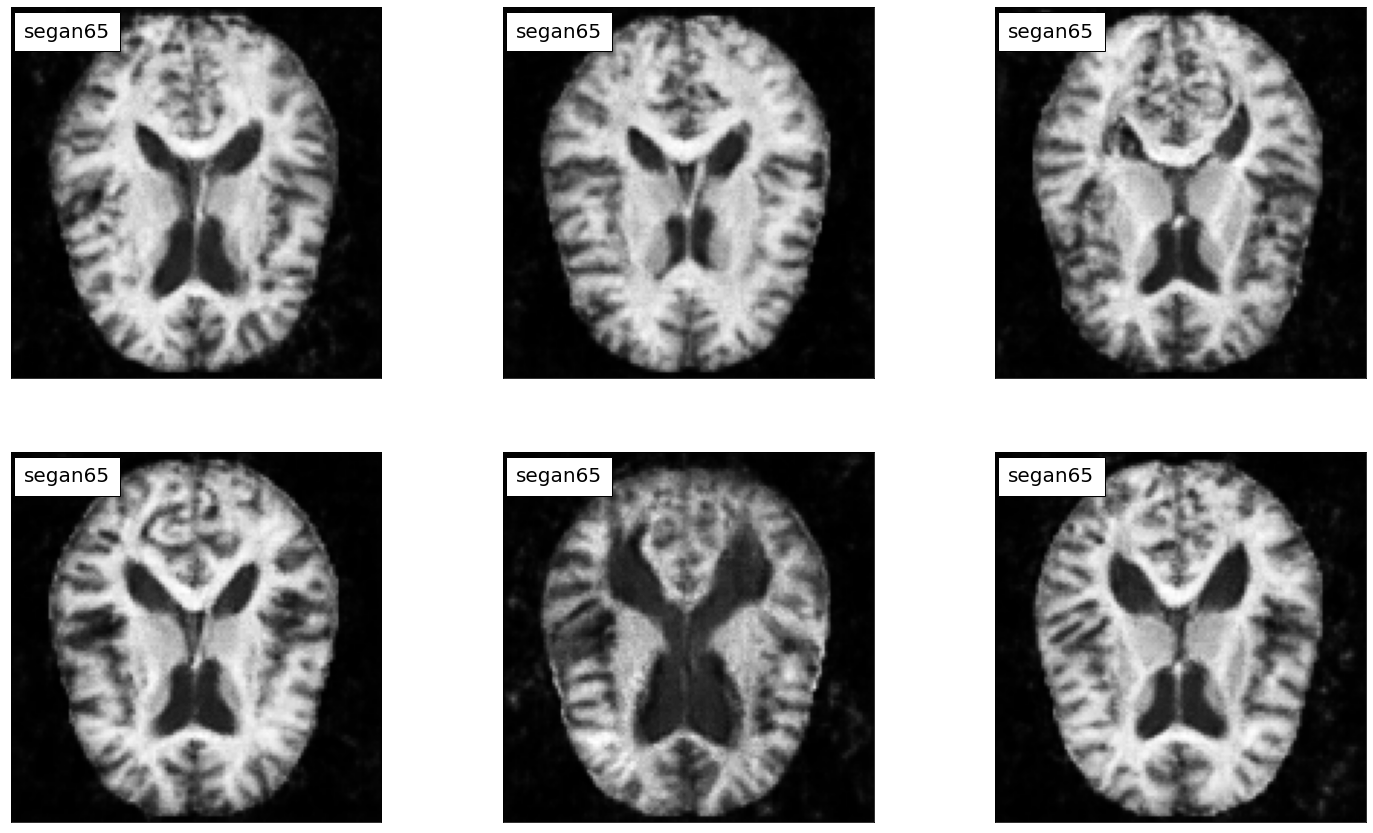

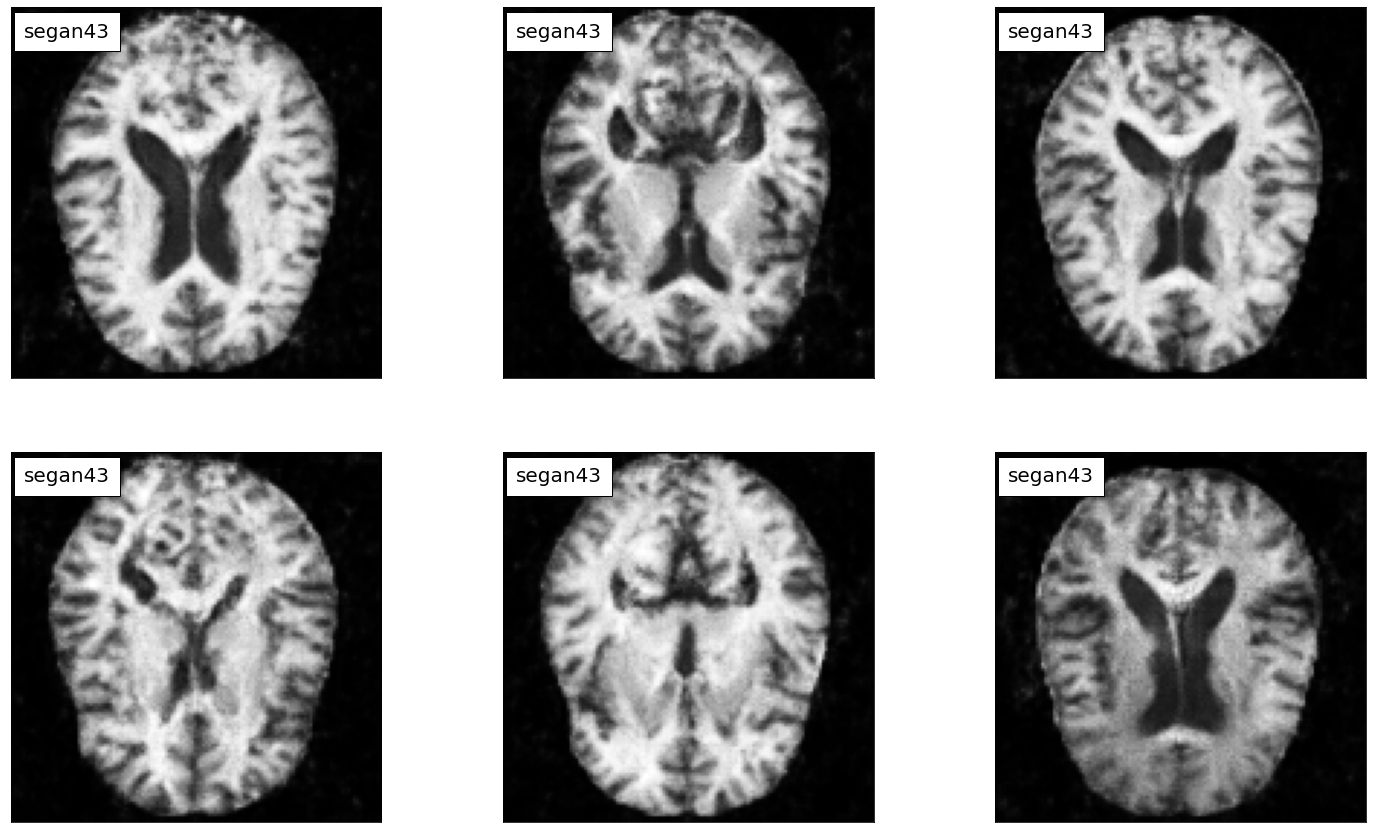

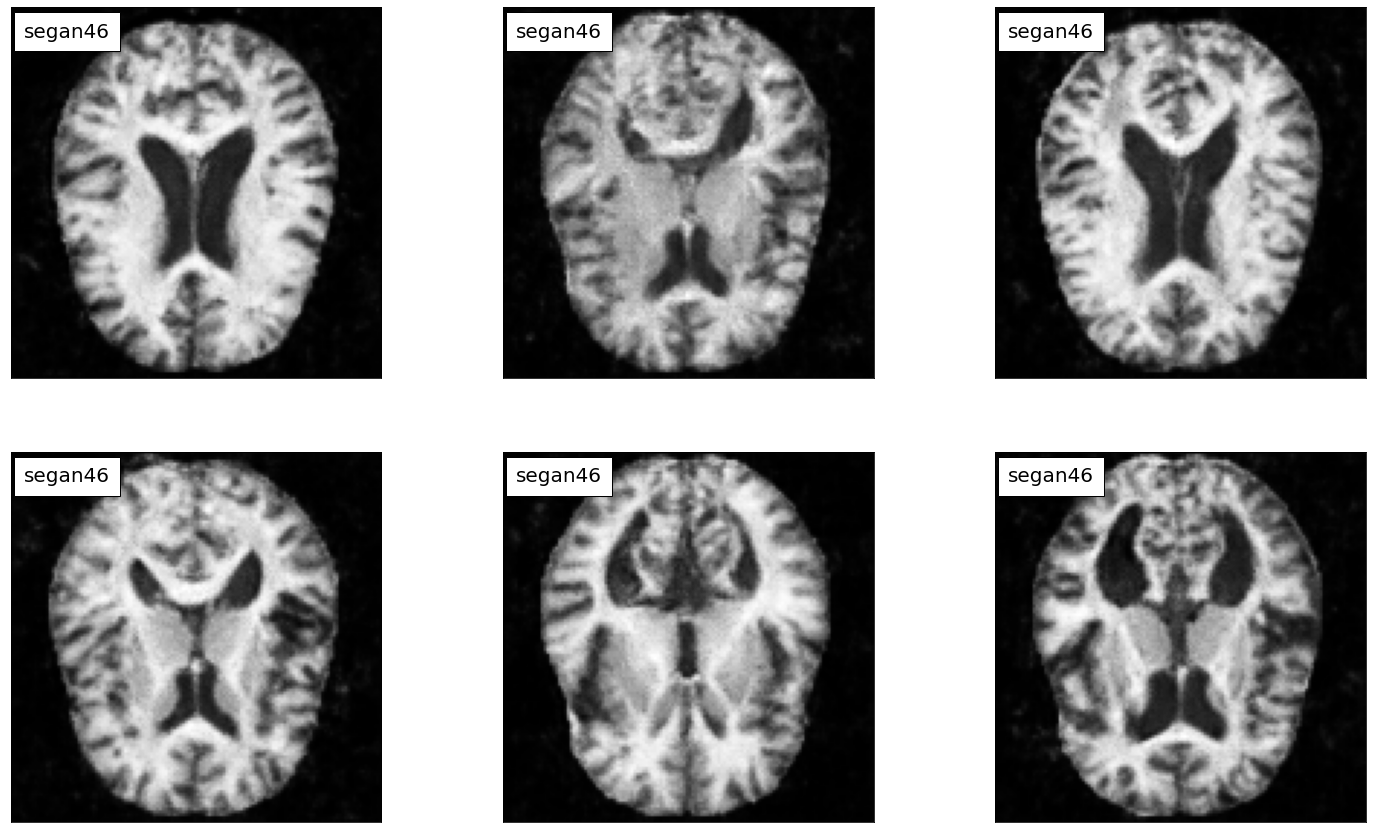

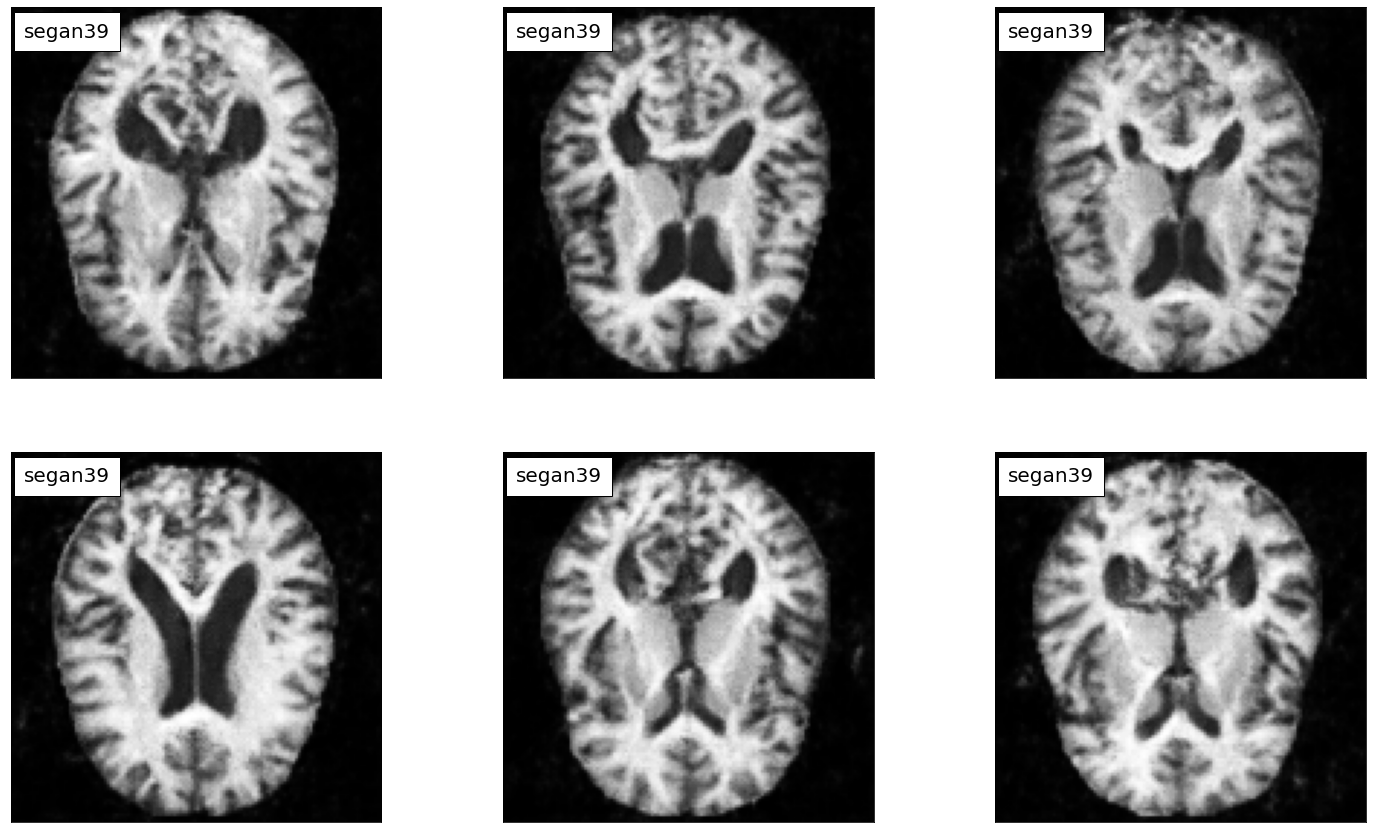

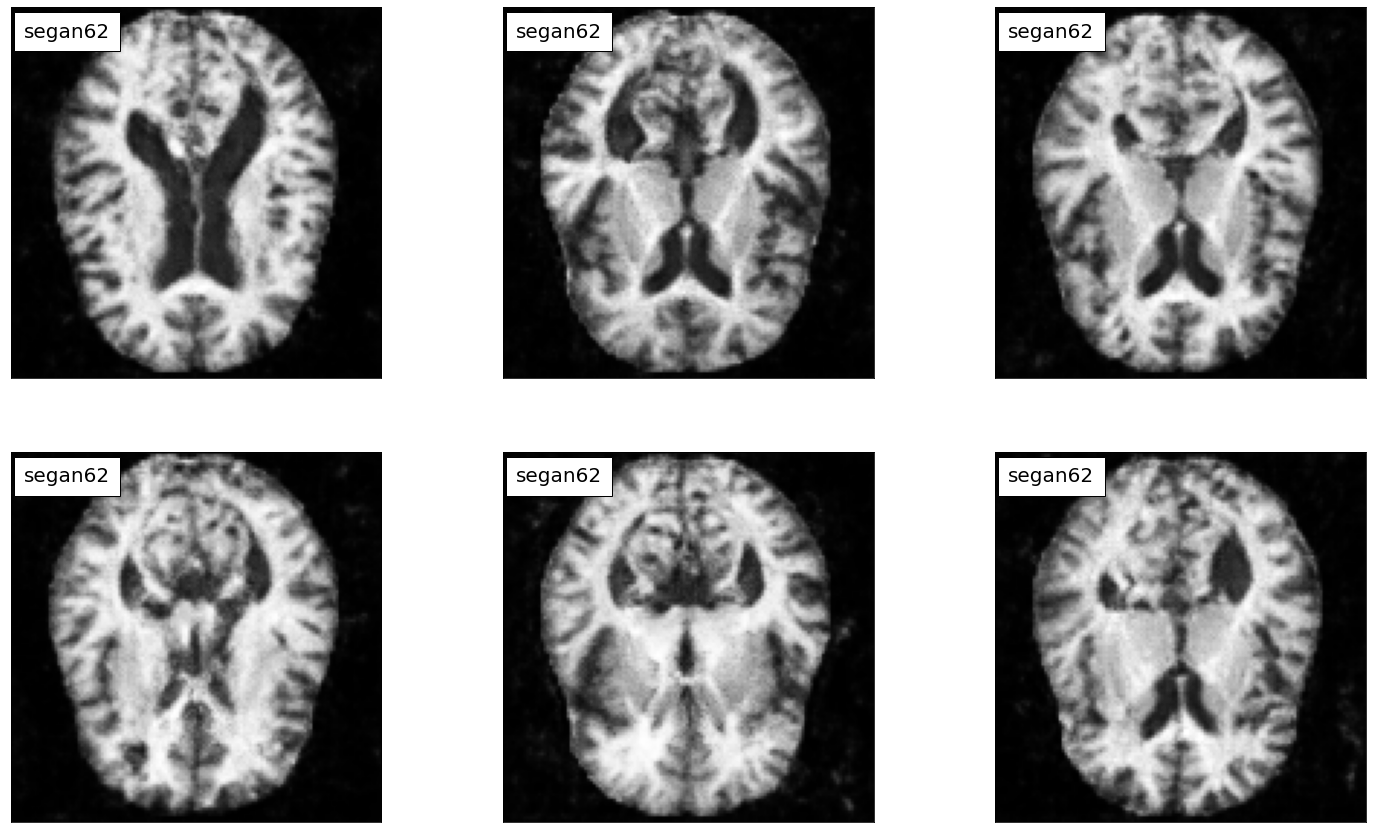

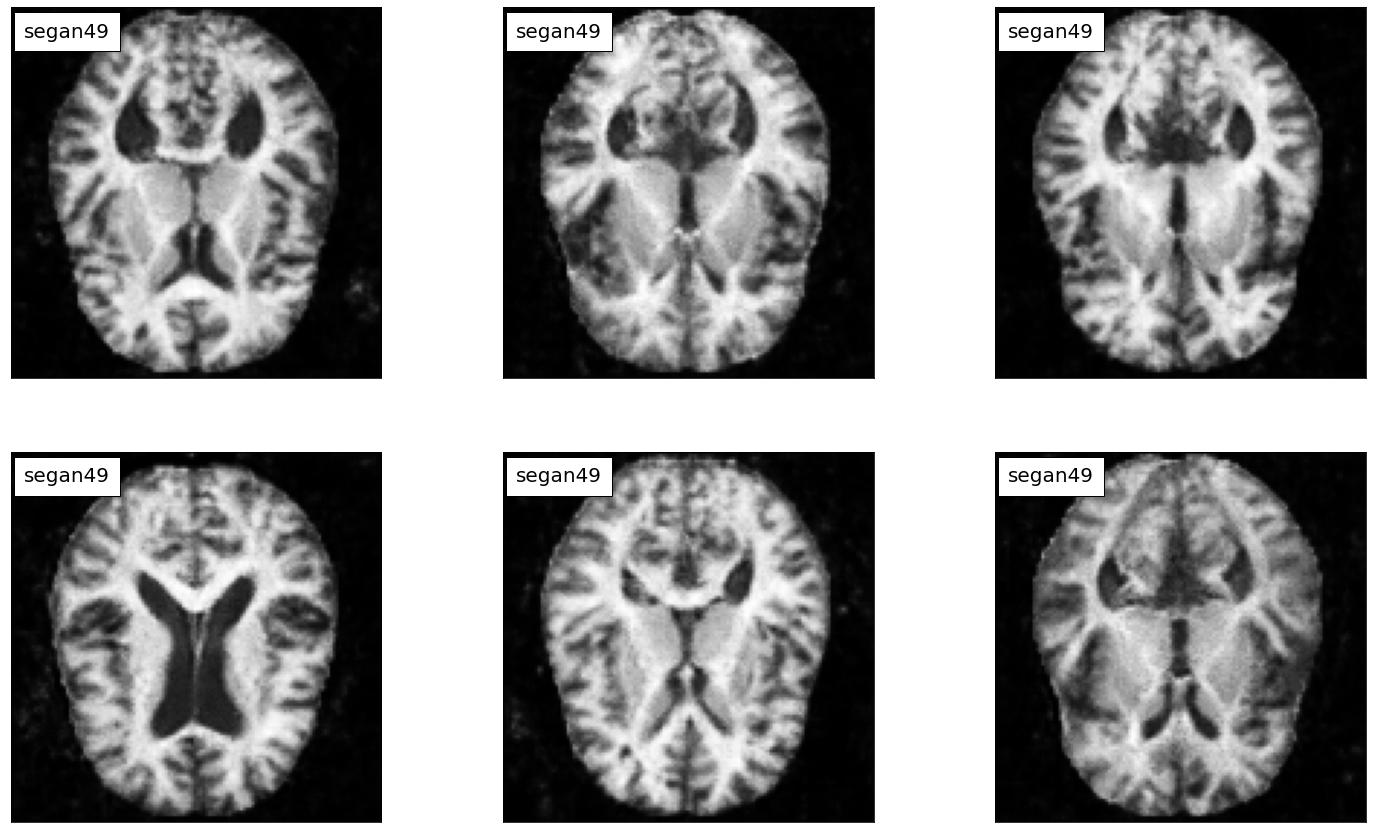

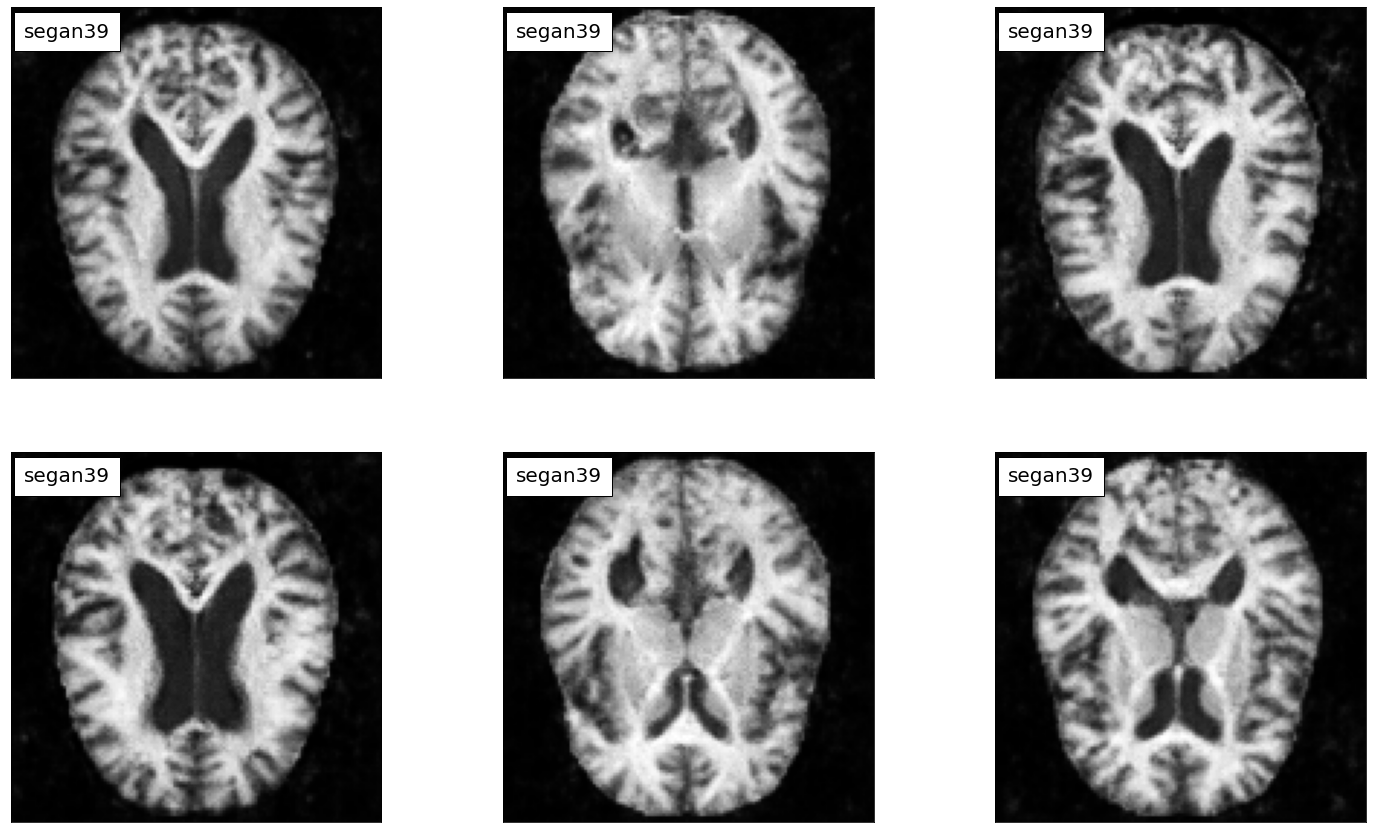

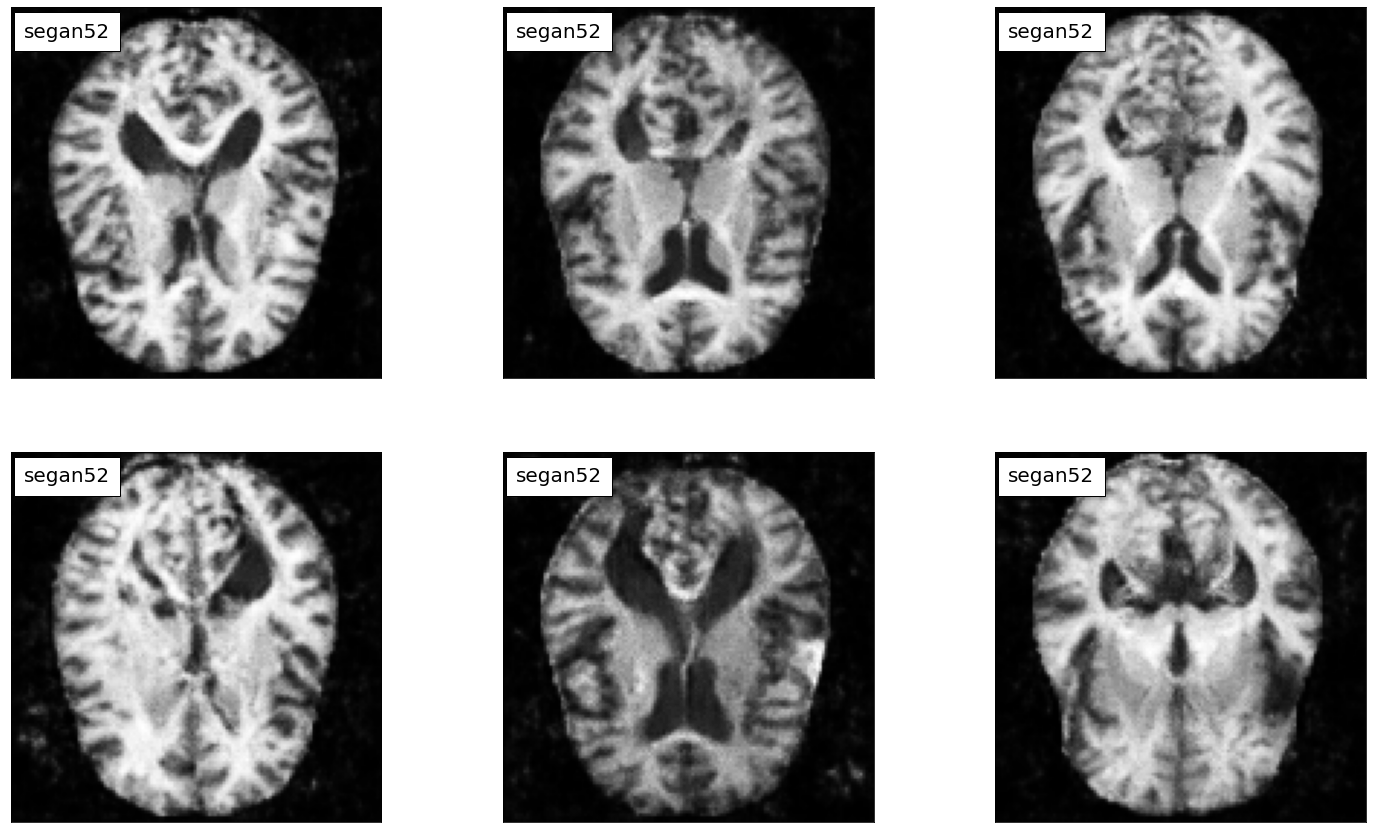

In [8]:
for model_num in index_models_to_save:
    model_path = f'{models_folder}/segan{model_num}'
    print(f' *** instantiating model: {model_path}')

    _, generator = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)
    generator.load_state_dict(torch.load(model_path))
    generator.eval()
    
    sample_size = 6
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if is_train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)

    view_samples(samples_z, legend_lbl=f"segan{model_num}")

We can see that for any trained and saved model, we can successfully generate brain MRIs using seGANs models.